# Hands-On Support Vector Classifier / Support Vector Machine
***

In this notebook we'll explore the details of the **Soft-Margin Support Vector Classifier** and look at how the choice of tuning parameters  affects the learned models.  We'll also look at kernel SVMs for non-linearly separable and methods for choosing and visualizing good hyperparameters.  

Other info on the practicalities of SVM:

[Very thorough guide](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf) on the practical use and tuning of SVMs, from the creators of libsvm.

[The time and space complexity of SVM in Scikit-Learn](https://scikit-learn.org/stable/modules/svm.html#complexity)

Some advanced things:

[The optimization algorithm used in Scikit-Learn for SVM](http://www.jmlr.org/papers/volume6/fan05a/fan05a.pdf)

[The SMO Algorithm](http://cs229.stanford.edu/materials/smo.pdf)

**Note**: There are some helper functions at the bottom of this notebook.  Scroll down and execute those cells before continuing. 

In [2]:
import numpy as np

### Part 1: Linear Hyperplane Seperator vs. Soft-Margin Support Vector Classifier
***

Suppose you have the following labeled data set (assume here that red corresponds to $y=1$ and blue corresponds to $y = -1$) and suppose the max-margin decision boundary in the seperable case is defined by the weights ${\bf w} = [-1/4, ~ 1/4]^T$ and $b = -1/4$. 


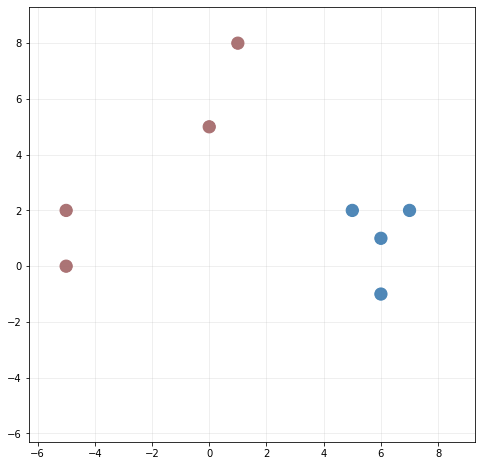

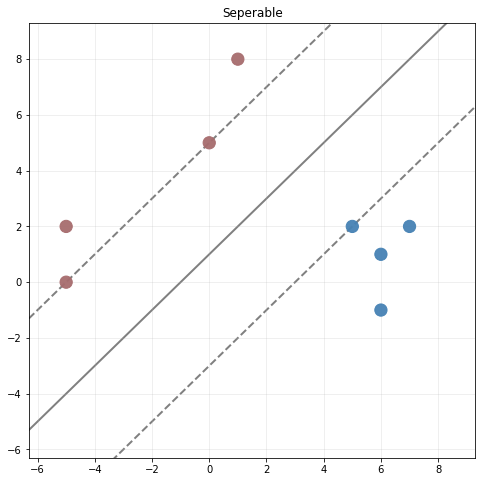

In [3]:
# Data and Labels - Non-Seperable
def generate_nonseperable_data():
    X = np.array([[1,8],[7,2],[6,-1],[-5,0], [-5,1], [-5,2],[6,3],[6,1],[5,2]])
    y = np.array([1,-1,-1,1,-1,1,1,-1,-1])
    return X,y

def generate_seperable_data():
    X = np.array([[1,8],[7,2],[6,-1],[-5,0], [-5,2],[6,1],[5,2],[0,5]])
    y = np.array([1,-1,-1,1,1,-1,-1, 1])
    return X,y

# Support vector parameters 
X_sep, y_sep = generate_seperable_data()
X_nonsep, y_nonsep = generate_nonseperable_data()
w, b = np.array([-1/4, 1/4]), -1/4
# w, b = np.array([-1/2, 1/2]), -1/2

# Plot the data and support vector boundaries 
# We will uncomment these lines one-by-one to discuss terminology

# Seperable set of points
linear_plot(X_sep, y_sep, w=None, b=None, title="Seperable")

# Seperable set of points with a max-margin hyper-plane classifier
linear_plot(X_sep, y_sep, w=w, b=b, title="Seperable")

# non seperable set of points
#linear_plot(X_nonsep, y_nonsep, w=None, b=None, title="Non-Seperable")

# Non-seperable set of points with a soft-margin classifier
#linear_plot(X_nonsep, y_nonsep, w=w, b=b, title="Non-Seperable")

**Question 1**: What is the **margin** of the classifier?

**Solution**: The margin is given by $M = 2 / \|{\bf w}\|$, or $1/ \|{\bf w}\|$ for half the margin. 

In [4]:
margin = 2/np.linalg.norm(w)
print("The norm of the weight vector: {:3f}".format(np.linalg.norm(w)))
print("M = {:.3f}".format(margin))

The norm of the weight vector: 0.353553
M = 5.657


**Question 2**: What is the distance of each point to the center of the margin?

In [6]:
for x_i, y_i in zip(X_sep, y_sep):
    print("Point: {} Label: {} Distance to Margin Center: {:.2f}".format(x_i, y_i, (np.dot(x_i, w/np.linalg.norm(w)) + b) * y_i))

Point: [1 8] Label: 1 Distance to Margin Center: 4.70
Point: [7 2] Label: -1 Distance to Margin Center: 3.79
Point: [ 6 -1] Label: -1 Distance to Margin Center: 5.20
Point: [-5  0] Label: 1 Distance to Margin Center: 3.29
Point: [-5  2] Label: 1 Distance to Margin Center: 4.70
Point: [6 1] Label: -1 Distance to Margin Center: 3.79
Point: [5 2] Label: -1 Distance to Margin Center: 2.37
Point: [0 5] Label: 1 Distance to Margin Center: 3.29


**Question 3**: Which training examples are the support vectors in the seperable case? Which in the non-seperable case? 

1. The points that are on the boundary for separable. 
2. the points that are misclassified 

# only points that are support vectors contribute

**Question 4**: Which training examples have nonzero slack? 

slack is either 0 or positive for misclassified points, distanee from correct boundary to misclassifed point

**Question 5**: Compute the slack $\xi_i$ associated with the misclassified points. Do these values jive with the plot of the data and the support vector boundaries? 

**How to find the slack:**: We will use the definition $(1/\|{\bf w}\|)y_i({\bf w}^T{\bf x}_i + b ) = (1/\|{\bf w}\| - \xi_i)$ to compute the slack.  Solving for $\xi_i$ gives 

$$
\xi_i = (1 - y_i({\bf w}^T{\bf x}_i + b ))/(1/\| {\bf w} \| ) 
$$

In [7]:
print("Margin: {}".format(1/np.linalg.norm(w)))

xi4 = (1 - y_nonsep[4]*(np.dot(w, X_nonsep[4])) + b)/np.linalg.norm(w)
print("xi_4 = {:.3f}".format(xi4))

xi6 = (1- y_nonsep[6]*(np.dot(w, X_nonsep[6]) + b))/np.linalg.norm(w)
print("xi_6 = {:.3f}".format(xi6))

Margin: 2.82842712474619
xi_4 = 6.364
xi_6 = 5.657


### Part 2: The Margin vs Slack 
***

In this problem we'll figure out how to fit linear SVM models to data using sklearn.  Consider the data shown below. 


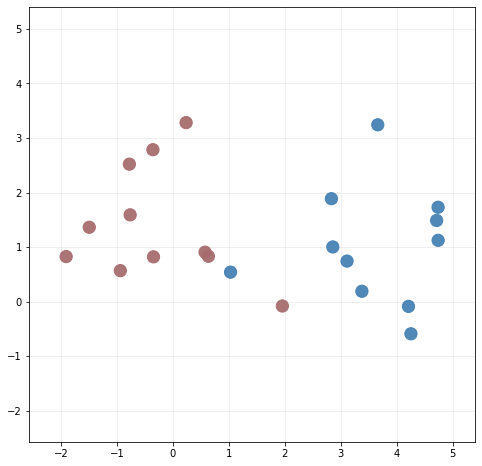

In [11]:
X, y = part2data()
linear_plot(X, y)

**Part A**: Let's fit a linear Soft-Margin SVM to the data above. For SVMs with a linear kernel we'll use the [`LinearSVM`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) method from sklearn's `svm` module.  Go now and look at the documentation. 

Recall that the primal objective function for the linear kernel SVM is as follows 


$$
\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2}\|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i
$$

The two optional parameters in `LinearSVM` that we'll be most concerned with are `C`, the hyperparameter weighting the slackness contribution to the primal objective function, and `loss`, which determines the exponent on the slack variables in the sum. 

Write some code below to train a linear SVM with $C=1$, get the computed weight vector and bias, and the plot the resulting model. 

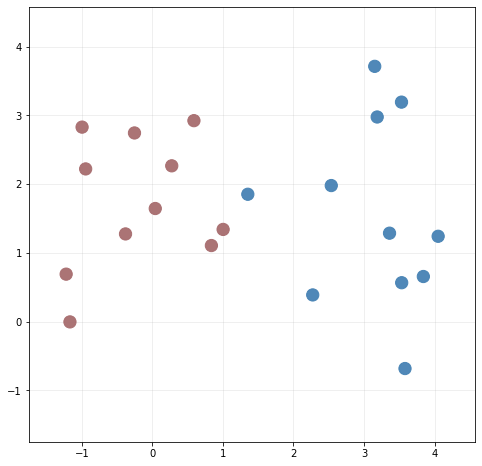

In [13]:
X, y = part2data()
linear_plot(X, y)

C:\Users\tsmar\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


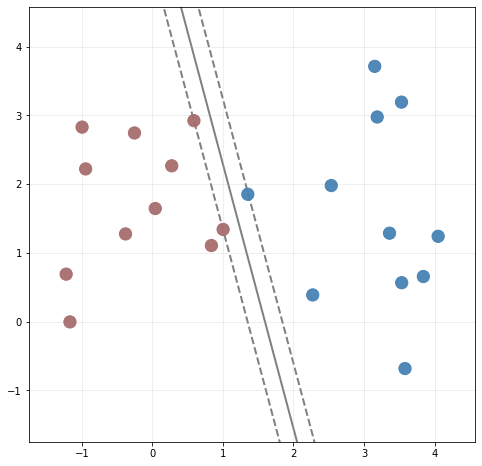

In [15]:
from sklearn.svm import LinearSVC


# TODO: Train the model and get the parameters, pay attention to the loss parameter
lsvm = LinearSVC(C=1000, loss="hinge")
lsvm.fit(X,y)
w = lsvm.coef_[0]
b = lsvm.intercept_

linear_plot(X, y, w=w, b=b)

**Part B**: Experiment with different values of `C`.  How does the choice of `C` affect the nature of the decision boundary and the associated margin? 

larger c values penalize large margins. -->Lead to smaller margins with less variables with non-zero slack

**Part D**: In general, how does the choice of `C` affect the bias and variance of the model? 

higher values of c have low bias and high variancem low values of c have high bias and low variance

### Part 3: Nonlinear SVM, Parameter Tuning, Accuracy, and Cross-Validation 
***

Any support vector machine classifier will have at least one parameter that needs to be tuned based on the training data.  The guaranteed parameter is the $C$ associated with the slack variables in the primal objective function, i.e. 

$$
\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2}\|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i
$$

If you use a kernel fancier than the linear kernel then you will likely have other parameters as well. For instance in the polynomial kernel $K({\bf x}, {\bf z}) = ({\bf x}^T{\bf z} + c)^d$ you have to select the shift $c$ and the polynomial degree $d$.  Similarly the rbf kernel

$$
K({\bf x}, {\bf z}) = \exp\left[-\gamma\|{\bf x} - {\bf z}\|^2\right]
$$

has one tuning parameter, namely $\gamma$, which controls how fast the similarity measure drops off with distance between ${\bf x}$ and ${\bf z}$. 

For our examples we'll consider the rbf kernel, which gives us two parameters to tune, namely $C$ and $\gamma$. 

Consider the following two dimensional data

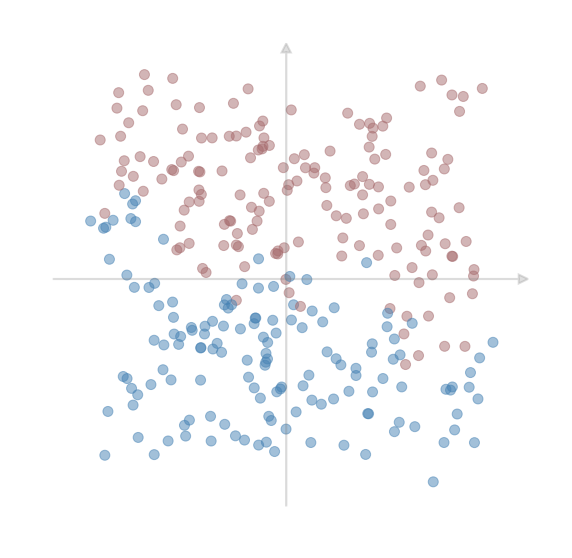

In [24]:
X, y = part3data(N=300, seed=1235)
nonlinear_plot(X, y)

**Part A**: We can use the method [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) from sklearn's `svm` module to fit an SVM with a nonlinear kernel to the data.  Go now and look at the documentation. Note that we pass the `kernel="rbr"` parameter to use the RBF kernel.  The other two parameters we'll be concerned with are `C` and the RBF parameter `gamma`.   

Write some code to fit an SVM with RBF kernel to the data and plot the results.  Use the parameter values `C=1` and `gamma=1`. 

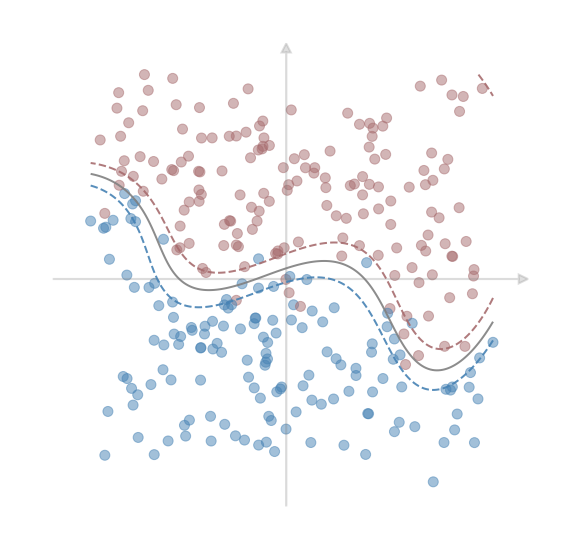

In [26]:
from sklearn.svm import SVC

nlsvm = SVC(kernel="rbf", C=200.0, gamma=1)
nlsvm.fit(X, y)

nonlinear_plot(X, y, nlsvm)

**Part B**: In this part we'll use cross-validation to estimate the validation accuracy achieved by our model.  Experiment with the values of the hyperparameters to see if you can get a good validation accuracy. How do the choice of `C` and `gamma` affect the resulting decision boundary? 


cross-val mean-accuracy: 0.947


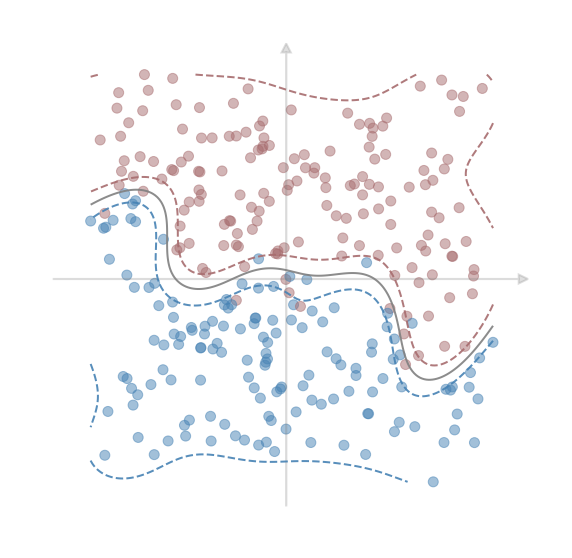

In [31]:
from sklearn.model_selection import cross_val_score

nlsvm = SVC(kernel="rbf", C=16, gamma=5.65)
scores = cross_val_score(nlsvm, X, y, cv=5)
print("cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))

nonlinear_plot(X, y, nlsvm)

**Part C**: How does the choice of **kernel** function affect the bias/variance of the model?  


# higher gamma means more variance lower gamma means lower var

### Part 4: Automating the Parameter Search 
***

On the previous problem we were able to choose some OK parameters just by hand-tuning.  But in real life (where time is money) it would be better to do something a little more automated.  One common thing to do is a **grid-search** over a predefined range of the parameters.  In this case you will loop over all possible combinations of parameters, estimate the accuracy of your model using K-Folds cross-validation, and then choose the parameter combination that produces the highest validation accuracy. 

**Part A**: Below is an experiment where we search over a logarithmic range between $2^{-5}$ and $2^{5}$ for $C$ and a range between $2^{-5}$ and $2^{5}$ for $\gamma$.  For the accuracy measure we use K-Folds CV with $K=3$.

In [298]:
from sklearn.model_selection import cross_val_score, GridSearchCV

c_range = np.logspace(-5, 10, 11, base=2)
g_range = np.logspace(-5, 10, 11, base=2)
param_grid = {
    'gamma': g_range,
    'C': c_range
}
grid = GridSearchCV(SVC(kernel="rbf"), param_grid=param_grid, cv=3)
grid.fit(X, y)

/home/chris/anaconda3/envs/nbgrader/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([3.12500000e-02, 8.83883476e-...
       2.00000000e+00, 5.65685425e+00, 1.60000000e+01, 4.52548340e+01,
       1.28000000e+02, 3.62038672e+02, 1.02400000e+03]),
                         'gamma': array([3.12500000e-02, 8.83883476e-02, 2.50000000e-01, 7.07106781e-01,
       2.00000000e+00, 5.65685425e+00, 1.60000000e+01, 4.52548340e+01,
       1.28000000e+02, 3.62038672e+02, 1.02400000e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

**Part B**: The following function will plot a heat-map of the cross-validation accuracies for each combination of parameters.  Which combination looks the best?

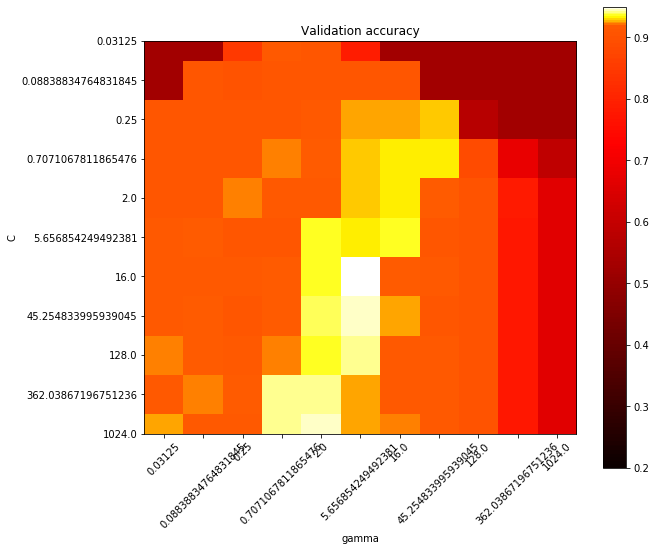

In [299]:
plotSearchGrid(grid)

**Part C**: The GridSearchCV object scores, among other things, the best combination of parameters as well as the cross-validation accuracy achieved with those parameters.  Print those quantities for our model. 

In [300]:
print("best parameters: ", grid.best_params_)
print("best accuracy: ", grid.best_score_)

best parameters:  {'C': 16.0, 'gamma': 5.656854249492381}
best accuracy:  0.95


**Part D**: The GridSearchCV object also stores the classifier trained with the best hyperparameters.  Pass this best estimator into the `nonlinear_plot` function to view the best decision boundary. 

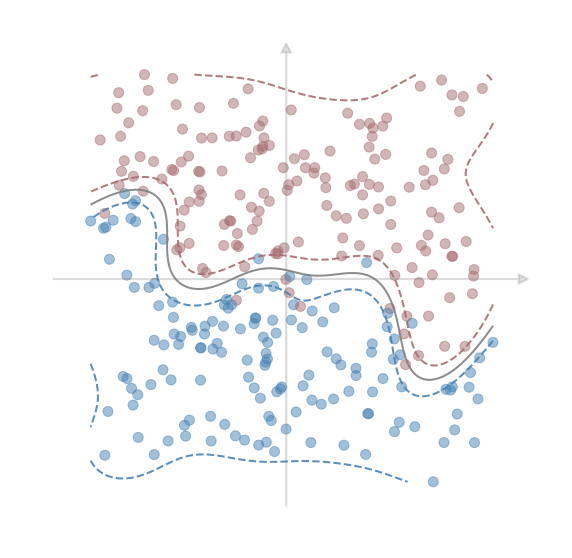

In [301]:
nonlinear_plot(X, y, grid.best_estimator_)

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

### Helper Functions
***

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
%matplotlib inline

def linear_plot(X, y, w=None, b=None, title = ""):
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    
    # Plot data 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.scatter(X[:,0], X[:,1], color=colors, s=150, alpha=0.95, zorder=2)
    
    # Plot boundaries 
    lower_left = np.min([np.min(X[:,0]), np.min(X[:,1])])
    upper_right = np.max([np.max(X[:,0]), np.max(X[:,1])])
    gap = .1*(upper_right-lower_left)
    xplot = np.linspace(lower_left-gap, upper_right+gap, 20)
    if w is not None and b is not None: 
        ax.plot(xplot, (-b - w[0]*xplot)/w[1], color="gray", lw=2, zorder=1)
        ax.plot(xplot, ( 1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        ax.plot(xplot, (-1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        ax.set_title(title)
    
    ax.set_xlim([lower_left-gap, upper_right+gap])
    ax.set_ylim([lower_left-gap, upper_right+gap])
    
    ax.grid(alpha=0.25)
    
def part2data():
        
    '''
    X = np.zeros((22,2))
    X[0:10,0]  = 1.5*np.random.rand(10) 
    X[0:10,1]  = 1.5*np.random.rand(10)
    X[10:20,0] = 1.5*np.random.rand(10) +  1.75
    X[10:20,1] = 1.5*np.random.rand(10) +  1
    X[20,0] = 1.5
    X[20,1] = 2.25
    X[21,0] = 1.6
    X[21,1] = 0.25
    
    X = X + np.random.standard_normal(X.shape)*0.5
    '''
    y = np.ones(22)
    y[11:] = -1 
    
    X = np.zeros((22,2))
    X[:11,:] = np.random.randn(11,2)+np.array([0, 1.5])
    X[11:,:] = np.random.randn(11,2)+np.array([3.5,1.5])
    
    return X, y

def part3data(N=100, seed=1235):
    
    np.random.seed(seed)
    
    X = np.random.uniform(-1,1,(N,2))
    y = np.array([1 if y-x > 0 else -1 for (x,y) in zip(X[:,0]**2 * np.sin(2*np.pi*X[:,0]), X[:,1])])
    X = X + np.random.normal(0,.1,(N,2))
    
    return X, y

def nonlinear_plot(X, y, clf=None, title=""): 
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    ax.scatter(X[:,0],X[:,1], marker='o', color=colors, s=100, alpha=0.5)
    
    ax.arrow(-1.25,0,2.5,0, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    ax.arrow(0,-1.25,0,2.5, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    z = np.linspace(0.25,3.5,10)
    
    ax.set_xlim([-1.50,1.50])
    ax.set_ylim([-1.50,1.50])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([], fontsize=16)
    plt.yticks([], fontsize=16)
    

    if clf: 
        
        clf.fit(X,y)

        x_min = X[:, 0].min()+.00
        x_max = X[:, 0].max()-.00
        y_min = X[:, 1].min()+.00
        y_max = X[:, 1].max()-.00

        colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.contour(XX, YY, Z, colors=[mycolors["blue"], "gray", mycolors["red"]], linestyles=['--', '-', '--'],
                    levels=[-0.9, 0, 0.9], linewidths=[2,2,2], alpha=0.9)
    

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()

from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")